In [4]:
# построение индекса
!hisat2-build data/Saccharomyces_cerevisiae.R64-1-1.75.dna.toplevel.fa ref_hisat.index

Settings:
  Output files: "ref_hisat.index.*.ht2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Local offset rate: 3 (one in 8)
  Local fTable chars: 6
  Local sequence length: 57344
  Local sequence overlap between two consecutive indexes: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/Saccharomyces_cerevisiae.R64-1-1.75.dna.toplevel.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
  Time to read SNPs and splice sites: 00:00:00
Using parameters --bmax 2279457 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 2279457 --

In [ ]:
# это мне надо было, чтобы понять, какая направленность у стрэндов
!gtf2bed < data/Saccharomyces_cerevisiae.R64-1-1.75.gtf > ref.bed

In [46]:
# как выяснилось, никакая, поэтому пришлось найти аргумент --dta-cufflinks у hisat2
!infer_experiment.py -r ref.bed -i hisat_alignment.sam

Reading reference gene model ref.bed ... Done
Loading SAM/BAM file ...  Total 200000 usable reads were sampled


This is PairEnd Data
Fraction of reads failed to determine: 0.0456
Fraction of reads explained by "1++,1--,2+-,2-+": 0.4813
Fraction of reads explained by "1+-,1-+,2++,2--": 0.4731


In [12]:
# выравнивание и получение .bam
!hisat2 -x ref_hisat.index -p 6 -1 data/SRR453566_1.fastq -2 data/SRR453566_2.fastq --dta-cufflinks | samtools \
sort > hisat2.bam

5725730 reads; of these:
  5725730 (100.00%) were paired; of these:
    1222960 (21.36%) aligned concordantly 0 times
    4258584 (74.38%) aligned concordantly exactly 1 time
    244186 (4.26%) aligned concordantly >1 times
    ----
    1222960 pairs aligned concordantly 0 times; of these:
      128458 (10.50%) aligned discordantly 1 time
    ----
    1094502 pairs aligned 0 times concordantly or discordantly; of these:
      2189004 mates make up the pairs; of these:
        1471502 (67.22%) aligned 0 times
        662558 (30.27%) aligned exactly 1 time
        54944 (2.51%) aligned >1 times
87.15% overall alignment rate
[bam_sort_core] merging from 4 files and 1 in-memory blocks...


In [13]:
# в пайплайне cufflinks написано, что после этого можно использовать cuffnorm, но он хочет два .cxb файла
# я не поняла, где надо было взять второй, поэтому использовала cufflinks
!./cufflinks-2.2.1/cuffquant -p 6 data/Saccharomyces_cerevisiae.R64-1-1.75.gtf hisat2.bam

[23:15:24] Loading reference annotation.
[23:15:25] Inspecting maps and determining fragment length distributions.
> Map Properties:
>	Normalized Map Mass: 3590493.00
>	Raw Map Mass: 3590609.35
>	Fragment Length Distribution: Empirical (learned)
>	              Estimated Mean: 206.33
>	           Estimated Std Dev: 98.38
[23:16:21] Calculating preliminary abundance estimates
[23:16:21] Quantifying expression levels in locus.
> Processed 6369 loci.                         [*************************] 100%


In [24]:
# тут считается FPKM
!./cufflinks-2.2.1/cufflinks -p 6 -g data/Saccharomyces_cerevisiae.R64-1-1.75.gtf hisat2.bam

[23:35:31] Loading reference annotation.
[23:35:31] Inspecting reads and determining fragment length distribution.
> Processed 1660 loci.                         [*************************] 100%
> Map Properties:
>	Normalized Map Mass: 4988472.84
>	Raw Map Mass: 4988472.84
>	Fragment Length Distribution: Empirical (learned)
>	              Estimated Mean: 206.32
>	           Estimated Std Dev: 99.09
[23:36:45] Assembling transcripts and estimating abundances.
> Processed 1660 loci.                         [*************************] 100%


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# файл с генами и их FPKM
data = pd.read_csv('genes.fpkm_tracking', sep='\t')

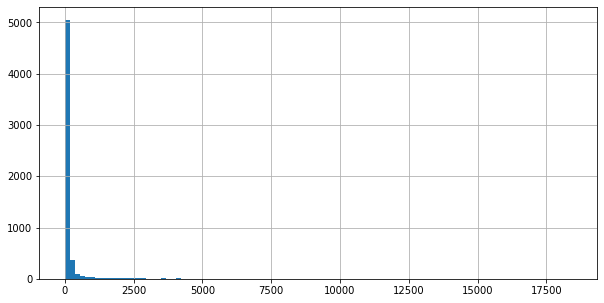

In [38]:
# общее распределение
plt.figure(figsize=(10, 5))
data.FPKM.hist(bins=100)

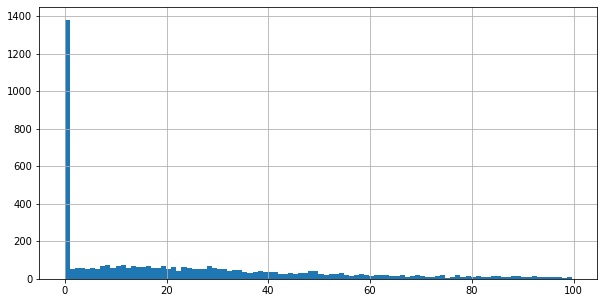

In [37]:
# выглядит одинаково... 
plt.figure(figsize=(10, 5))
data.loc[data.FPKM < 100].FPKM.hist(bins=100)

In [36]:
# мне понравилось число 5
cutoff = 5

In [45]:
print(f'Процент экспрессирующихся генов с FPKM > {cutoff} равен '
      f'{(len(data) - len(data.loc[data.FPKM > cutoff])) / len(data) * 100:.2f}%')

Процент экспрессирующихся генов с FPKM > 5 равен 27.55%
